### Import

In [1]:
import os
import pandas as pd
import numpy as np
import qlib
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data import D
from qlib.data.filter import NameDFilter
from qlib.constant import REG_CN
from qlib.utils import exists_qlib_data, init_instance_by_config
from qlib.workflow import R
from qlib.workflow.record_temp import SignalRecord, PortAnaRecord
from qlib.utils import flatten_dict
from qlib.data.dataset.loader import QlibDataLoader
from qlib.data.dataset.handler import DataHandlerLP
from qlib.data.dataset.processor import ZScoreNorm, Fillna
from qlib.data.dataset import DatasetH, TSDatasetH

import lightgbm as lgb
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

torch.manual_seed(1)

### Get dataset

In [2]:
qlib.init(provider_uri='~/.qlib/qlib_data/cn_data')

[22440:MainThread](2022-06-29 19:47:37,358) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[22440:MainThread](2022-06-29 19:47:37,363) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[22440:MainThread](2022-06-29 19:47:37,364) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/.qlib/qlib_data/cn_data')}


In [77]:
# nameDFilter = NameDFilter(name_rule_re='SH000300')
# instruments = D.instruments(market='csi300', filter_pipe=[nameDFilter])
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money']
# data = D.features(instruments, fields, start_time='2008-01-01', end_time='2020-08-01', freq='day')
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money']])
df = qdl.load(instruments = ['SH000300'], start_time='2008-01-01', end_time='2020-08-01')

#### benefit

In [4]:
df1 = df.copy()

In [5]:
df1['target'] = df1['close'].diff()
df1['target'] = df1['target'] * 250


In [6]:
df1

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 SH000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 SH000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 SH000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 SH000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 SH000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 SH000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 SH000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 SH000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 SH000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 SH000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 SH000300    0.001018  5385.100098  0.008773  100618072.0        NaN  
2008-01-03 SH000300    0.001018  5422.029785  0.006858  138364608.0   9.394169  
2008-01-04 SH000300    0.001018  5483.649902  0.011365  120947744.0  15.674710  
2008-01-07 SH000300    0.001018  5556.589844  0.013301  125346768.0  18.554329  
2008-01-08 SH000300    0.001018  5528.049805 -0.005136  150567008.0  -7.259965  
...                         ...          ...       ...          ...        ...  
2020-07-27 SH000300    0.001018  4528.450195  0.005074  307179936.0   5.815148  
2020-07-28 SH000300    0.001018  4568.259766  0.008791  297963744.0  10.126710  
2020-07-29 SH000300    0.001018  4679.009766  0.024243  356569216.0  28.172375  
2020-07-30 SH000300    0.001018  4656.149902 -0.004886  329683104.0  -5.815029  
2020-07-31 SH000300    0.001018  4695.049805  0.008355  357267904.0   9.895325  

[3061 rows x 10 columns]

In [7]:
print(df1.target.max())
print(df1.target.min())

96.200584
-99.68054


In [8]:
df1.to_csv('dataset/dataset_benefit2/SH000300.csv')

In [9]:
!python ../scripts/dump_bin.py dump_all --csv_path dataset/dataset_benefit2/SH000300.csv --date_field_name datetime --qlib_dir dataset/dataset_benefit2_bin --exclude_fields instrument

2022-06-29 19:47:39.590 | INFO     | __main__:_get_all_date:272 - start get all date......

100%|██████████| 1/1 [00:03<00:00,  3.80s/it]
2022-06-29 19:47:43.390 | INFO     | __main__:_get_all_date:291 - end of get all date.

2022-06-29 19:47:43.390 | INFO     | __main__:_dump_calendars:294 - start dump calendars......
2022-06-29 19:47:43.430 | INFO     | __main__:_dump_calendars:297 - end of calendars dump.

2022-06-29 19:47:43.430 | INFO     | __main__:_dump_instruments:300 - start dump instruments......
2022-06-29 19:47:43.432 | INFO     | __main__:_dump_instruments:302 - end of instruments dump.

2022-06-29 19:47:43.432 | INFO     | __main__:_dump_features:305 - start dump features......

100%|██████████| 1/1 [00:03<00:00,  3.50s/it]
2022-06-29 19:47:46.929 | INFO     | __main__:_dump_features:312 - end of features dump.



### risk

In [10]:
df2 = df.copy()

In [11]:
df2['target'] = np.nan
for i in range(1, df2.target.size):
    miu = (df2.close[i] + df2.close[i - 1]) / 2
    df2.target[i] = ((df2.close[i - 1] - miu) ** 2 + (df2.close[i] - miu) ** 2) ** 0.5 + 0.001
df2.target *= 250

c:\Users\v-junmzhang\Anaconda3\envs\qlib\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [12]:
df2

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 SH000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 SH000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 SH000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 SH000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 SH000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 SH000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 SH000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 SH000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 SH000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 SH000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 SH000300    0.001018  5385.100098  0.008773  100618072.0        NaN  
2008-01-03 SH000300    0.001018  5422.029785  0.006858  138364608.0   6.892681  
2008-01-04 SH000300    0.001018  5483.649902  0.011365  120947744.0  11.333694  
2008-01-07 SH000300    0.001018  5556.589844  0.013301  125346768.0  13.369892  
2008-01-08 SH000300    0.001018  5528.049805 -0.005136  150567008.0   5.383570  
...                         ...          ...       ...          ...        ...  
2020-07-27 SH000300    0.001018  4528.450195  0.005074  307179936.0   4.361931  
2020-07-28 SH000300    0.001018  4568.259766  0.008791  297963744.0   7.410665  
2020-07-29 SH000300    0.001018  4679.009766  0.024243  356569216.0  20.170877  
2020-07-30 SH000300    0.001018  4656.149902 -0.004886  329683104.0   4.361847  
2020-07-31 SH000300    0.001018  4695.049805  0.008355  357267904.0   7.247051  

[3061 rows x 10 columns]

In [13]:
print(df2.target.max())
print(df2.target.min())

70.73478786942616
0.25


In [14]:
df2.to_csv('dataset/dataset_risk2/SH000300.csv')

In [15]:
!python ../scripts/dump_bin.py dump_all --csv_path dataset/dataset_risk2/SH000300.csv --date_field_name datetime --qlib_dir dataset/dataset_risk2_bin --exclude_fields instrument

2022-06-29 19:47:50.349 | INFO     | __main__:_get_all_date:272 - start get all date......

100%|██████████| 1/1 [00:03<00:00,  3.77s/it]
2022-06-29 19:47:54.117 | INFO     | __main__:_get_all_date:291 - end of get all date.

2022-06-29 19:47:54.117 | INFO     | __main__:_dump_calendars:294 - start dump calendars......
2022-06-29 19:47:54.151 | INFO     | __main__:_dump_calendars:297 - end of calendars dump.

2022-06-29 19:47:54.151 | INFO     | __main__:_dump_instruments:300 - start dump instruments......
2022-06-29 19:47:54.153 | INFO     | __main__:_dump_instruments:302 - end of instruments dump.

2022-06-29 19:47:54.153 | INFO     | __main__:_dump_features:305 - start dump features......

100%|██████████| 1/1 [00:03<00:00,  3.57s/it]
2022-06-29 19:47:57.723 | INFO     | __main__:_dump_features:312 - end of features dump.



### Train model - benefit

In [16]:
provider_uri = "./dataset/dataset_benefit2_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)

[22440:MainThread](2022-06-29 19:47:58,027) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[22440:MainThread](2022-06-29 19:47:58,032) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[22440:MainThread](2022-06-29 19:47:58,034) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_benefit2_bin')}


In [17]:
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0        NaN  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   9.394169  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  15.674710  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  18.554329  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0  -7.259965  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   5.815148  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0  10.126710  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  28.172375  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0  -5.815029  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   9.895325  

[3061 rows x 10 columns]

In [18]:
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)

[22440:MainThread](2022-06-29 19:47:58,658) INFO - qlib.timer - [log.py:113] - Time cost: 0.008s | Loading data Done
[22440:MainThread](2022-06-29 19:47:58,660) INFO - qlib.timer - [log.py:113] - Time cost: 0.000s | Fillna Done
[22440:MainThread](2022-06-29 19:47:58,662) INFO - qlib.timer - [log.py:113] - Time cost: 0.001s | fit & process data Done
[22440:MainThread](2022-06-29 19:47:58,663) INFO - qlib.timer - [log.py:113] - Time cost: 0.012s | Init data Done


In [19]:
dh.fetch()

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     0.0   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     0.0   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     0.0   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     0.0   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     0.0   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     0.0   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     0.0   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     0.0   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     0.0   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0   0.000000  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   9.394169  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  15.674710  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  18.554329  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0  -7.259965  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   5.815148  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0  10.126710  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  28.172375  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0  -5.815029  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   9.895325  

[3061 rows x 10 columns]

In [20]:
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

In [21]:
ds.prepare('train')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     0.0   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     0.0   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     0.0   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     0.0   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     0.0   
...                         ...       ...       ...       ...     ...   
2016-12-26 sh000300    3.350889  3.380580  3.380600  3.324260     0.0   
2016-12-27 sh000300    3.377334  3.374465  3.388547  3.373895     0.0   
2016-12-28 sh000300    3.373813  3.359711  3.378697  3.350838     0.0   
2016-12-29 sh000300    3.354776  3.355508  3.370110  3.345679     0.0   
2016-12-30 sh000300    3.360433  3.368044  3.371575  3.353463     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0   0.000000  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   9.394169  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  15.674710  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  18.554329  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0  -7.259965  
...                         ...          ...       ...          ...        ...  
2016-12-26 sh000300    0.001018  3322.399902  0.004475   97165440.0   3.764749  
2016-12-27 sh000300    0.001018  3316.389893 -0.001809   81011336.0  -1.528800  
2016-12-28 sh000300    0.001018  3301.889893 -0.004372   73016456.0  -3.688455  
2016-12-29 sh000300    0.001018  3297.760010 -0.001251   77303352.0  -1.050591  
2016-12-30 sh000300    0.001018  3310.080078  0.003736   78268368.0   3.133953  

[2190 rows x 10 columns]

In [22]:
ds.prepare('valid')

open     close      high       low  volumn  \
datetime   instrument                                                   
2017-01-03 sh000300    3.371982  3.400757  3.403840  3.371982     0.0   
2017-01-04 sh000300    3.399058  3.427294  3.428576  3.396605     0.0   
2017-01-05 sh000300    3.427324  3.426765  3.432483  3.420324     0.0   
2017-01-06 sh000300    3.425808  3.406292  3.427864  3.405499     0.0   
2017-01-09 sh000300    3.404339  3.422807  3.425167  3.402914     0.0   
...                         ...       ...       ...       ...     ...   
2018-12-24 sh000300    3.068305  3.091403  3.093591  3.059993     0.0   
2018-12-25 sh000300    3.059535  3.070117  3.083202  3.016799     0.0   
2018-12-26 sh000300    3.065629  3.054600  3.082103  3.048953     0.0   
2018-12-27 sh000300    3.096236  3.042878  3.100591  3.042878     0.0   
2018-12-28 sh000300    3.047243  3.063371  3.077311  3.037088     0.0   

                         factor     adjclose    change       money    target  
datetime   instrument                                                         
2017-01-03 sh000300    0.001018  3342.229980  0.009713  89146984.0  8.178234  
2017-01-04 sh000300    0.001018  3368.310059  0.007803  99730720.0  6.634176  
2017-01-05 sh000300    0.001018  3367.790039 -0.000154  92786192.0 -0.132263  
2017-01-06 sh000300    0.001018  3347.669922 -0.005974  92667056.0 -5.118132  
2017-01-09 sh000300    0.001018  3363.899902  0.004848  89455648.0  4.128575  
...                         ...          ...       ...         ...       ...  
2018-12-24 sh000300    0.001018  3038.199951  0.002905  64999380.0  2.238512  
2018-12-25 sh000300    0.001018  3017.280029 -0.006886  81821720.0 -5.321562  
2018-12-26 sh000300    0.001018  3002.030029 -0.005054  59600696.0 -3.879249  
2018-12-27 sh000300    0.001018  2990.510010 -0.003837  82580480.0 -2.930462  
2018-12-28 sh000300    0.001018  3010.649902  0.006735  79513744.0  5.123198  

[487 rows x 10 columns]

In [23]:
ds.prepare('test')

open     close      high       low  volumn  \
datetime   instrument                                                   
2019-01-02 sh000300    3.069903  3.021541  3.071643  3.010297     0.0   
2019-01-03 sh000300    3.014907  3.016758  3.052982  3.004966     0.0   
2019-01-04 sh000300    2.991677  3.089032  3.089989  2.987240     0.0   
2019-01-07 sh000300    3.108650  3.107785  3.115366  3.089073     0.0   
2019-01-08 sh000300    3.103277  3.101069  3.109016  3.091739     0.0   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     0.0   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     0.0   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     0.0   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     0.0   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2019-01-02 sh000300    0.001018  2969.540039 -0.013655   77438288.0 -10.457516  
2019-01-03 sh000300    0.001018  2964.840088 -0.001583   78007304.0  -1.195550  
2019-01-04 sh000300    0.001018  3035.870117  0.023957  109017224.0  18.068432  
2019-01-07 sh000300    0.001018  3054.300049  0.006071  107554960.0   4.688203  
2019-01-08 sh000300    0.001018  3047.699951 -0.002161   81023296.0  -1.678884  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   5.815148  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0  10.126710  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  28.172375  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0  -5.815029  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   9.895325  

[384 rows x 10 columns]

In [24]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

benefit_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [25]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [26]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1', 'auc', 'binary'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    "max_depth": 20,
}

In [27]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=5,
                valid_sets=lgb_valid,
                callbacks=[lgb.early_stopping(stopping_rounds=50)])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000187 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[4]	valid_0's auc: 0.676742	valid_0's l1: 6.6492	valid_0's binary_logloss: 8.08938	valid_0's l2: 85.9059


In [28]:
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

The RMSE of prediction is: 14.217644722827034


(-100.0, 100.0)

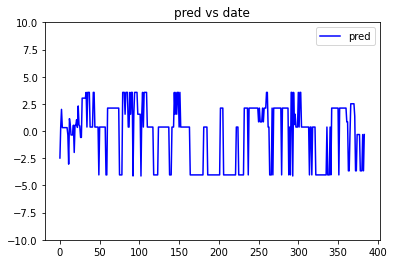

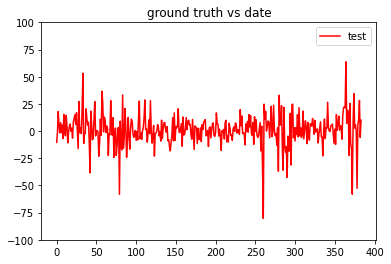

In [29]:
plt.plot(range(len(y_pred.tolist())), y_pred.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date")
plt.ylim([-10, 10])
plt.figure()
plt.plot(range(len(y_pred.tolist())), y_test, 'r', label='test')
plt.legend()
plt.title("ground truth vs date")
plt.ylim([-100, 100])

In [30]:
y_pred_benefit = y_pred

### Train model - risk

In [31]:
provider_uri = "./dataset/dataset_risk2_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)

[22440:MainThread](2022-06-29 19:48:02,308) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[22440:MainThread](2022-06-29 19:48:02,312) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[22440:MainThread](2022-06-29 19:48:02,313) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_risk2_bin')}


In [32]:
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     NaN   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     NaN   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     NaN   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     NaN   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     NaN   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     NaN   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     NaN   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     NaN   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     NaN   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     NaN   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0        NaN  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   6.892681  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  11.333694  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  13.369892  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0   5.383571  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   4.361931  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0   7.410665  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  20.170877  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0   4.361846  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   7.247051  

[3061 rows x 10 columns]

In [33]:
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)

[22440:MainThread](2022-06-29 19:48:03,160) INFO - qlib.timer - [log.py:113] - Time cost: 0.008s | Loading data Done
[22440:MainThread](2022-06-29 19:48:03,162) INFO - qlib.timer - [log.py:113] - Time cost: 0.000s | Fillna Done
[22440:MainThread](2022-06-29 19:48:03,163) INFO - qlib.timer - [log.py:113] - Time cost: 0.002s | fit & process data Done
[22440:MainThread](2022-06-29 19:48:03,164) INFO - qlib.timer - [log.py:113] - Time cost: 0.012s | Init data Done


In [34]:
dh.fetch()

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     0.0   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     0.0   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     0.0   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     0.0   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     0.0   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     0.0   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     0.0   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     0.0   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     0.0   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0   0.000000  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   6.892681  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  11.333694  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  13.369892  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0   5.383571  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   4.361931  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0   7.410665  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  20.170877  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0   4.361846  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   7.247051  

[3061 rows x 10 columns]

In [35]:
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

In [36]:
ds.prepare('train')

open     close      high       low  volumn  \
datetime   instrument                                                   
2008-01-02 sh000300    5.443442  5.479401  5.499578  5.375970     0.0   
2008-01-03 sh000300    5.475381  5.516977  5.517628  5.409039     0.0   
2008-01-04 sh000300    5.525728  5.579676  5.595376  5.517415     0.0   
2008-01-07 sh000300    5.576410  5.653893  5.666674  5.551033     0.0   
2008-01-08 sh000300    5.673593  5.624854  5.729220  5.581284     0.0   
...                         ...       ...       ...       ...     ...   
2016-12-26 sh000300    3.350889  3.380580  3.380600  3.324260     0.0   
2016-12-27 sh000300    3.377334  3.374465  3.388547  3.373895     0.0   
2016-12-28 sh000300    3.373813  3.359711  3.378697  3.350838     0.0   
2016-12-29 sh000300    3.354776  3.355508  3.370110  3.345679     0.0   
2016-12-30 sh000300    3.360433  3.368044  3.371575  3.353463     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2008-01-02 sh000300    0.001018  5385.100098  0.008773  100618072.0   0.000000  
2008-01-03 sh000300    0.001018  5422.029785  0.006858  138364608.0   6.892681  
2008-01-04 sh000300    0.001018  5483.649902  0.011365  120947744.0  11.333694  
2008-01-07 sh000300    0.001018  5556.589844  0.013301  125346768.0  13.369892  
2008-01-08 sh000300    0.001018  5528.049805 -0.005136  150567008.0   5.383571  
...                         ...          ...       ...          ...        ...  
2016-12-26 sh000300    0.001018  3322.399902  0.004475   97165440.0   2.912079  
2016-12-27 sh000300    0.001018  3316.389893 -0.001809   81011336.0   1.331025  
2016-12-28 sh000300    0.001018  3301.889893 -0.004372   73016456.0   2.858131  
2016-12-29 sh000300    0.001018  3297.760010 -0.001251   77303352.0   0.992880  
2016-12-30 sh000300    0.001018  3310.080078  0.003736   78268368.0   2.466039  

[2190 rows x 10 columns]

In [37]:
ds.prepare('valid')

open     close      high       low  volumn  \
datetime   instrument                                                   
2017-01-03 sh000300    3.371982  3.400757  3.403840  3.371982     0.0   
2017-01-04 sh000300    3.399058  3.427294  3.428576  3.396605     0.0   
2017-01-05 sh000300    3.427324  3.426765  3.432483  3.420324     0.0   
2017-01-06 sh000300    3.425808  3.406292  3.427864  3.405499     0.0   
2017-01-09 sh000300    3.404339  3.422807  3.425167  3.402914     0.0   
...                         ...       ...       ...       ...     ...   
2018-12-24 sh000300    3.068305  3.091403  3.093591  3.059993     0.0   
2018-12-25 sh000300    3.059535  3.070117  3.083202  3.016799     0.0   
2018-12-26 sh000300    3.065629  3.054600  3.082103  3.048953     0.0   
2018-12-27 sh000300    3.096236  3.042878  3.100591  3.042878     0.0   
2018-12-28 sh000300    3.047243  3.063371  3.077311  3.037088     0.0   

                         factor     adjclose    change       money    target  
datetime   instrument                                                         
2017-01-03 sh000300    0.001018  3342.229980  0.009713  89146984.0  6.032885  
2017-01-04 sh000300    0.001018  3368.310059  0.007803  99730720.0  4.941071  
2017-01-05 sh000300    0.001018  3367.790039 -0.000154  92786192.0  0.343524  
2017-01-06 sh000300    0.001018  3347.669922 -0.005974  92667056.0  3.869066  
2017-01-09 sh000300    0.001018  3363.899902  0.004848  89455648.0  3.169344  
...                         ...          ...       ...         ...       ...  
2018-12-24 sh000300    0.001018  3038.199951  0.002905  64999380.0  1.832867  
2018-12-25 sh000300    0.001018  3017.280029 -0.006886  81821720.0  4.012913  
2018-12-26 sh000300    0.001018  3002.030029 -0.005054  59600696.0  2.993043  
2018-12-27 sh000300    0.001018  2990.510010 -0.003837  82580480.0  2.322150  
2018-12-28 sh000300    0.001018  3010.649902  0.006735  79513744.0  3.872648  

[487 rows x 10 columns]

In [38]:
ds.prepare('test')

open     close      high       low  volumn  \
datetime   instrument                                                   
2019-01-02 sh000300    3.069903  3.021541  3.071643  3.010297     0.0   
2019-01-03 sh000300    3.014907  3.016758  3.052982  3.004966     0.0   
2019-01-04 sh000300    2.991677  3.089032  3.089989  2.987240     0.0   
2019-01-07 sh000300    3.108650  3.107785  3.115366  3.089073     0.0   
2019-01-08 sh000300    3.103277  3.101069  3.109016  3.091739     0.0   
...                         ...       ...       ...       ...     ...   
2020-07-27 sh000300    4.614424  4.607749  4.637939  4.560934     0.0   
2020-07-28 sh000300    4.647656  4.648256  4.670631  4.617141     0.0   
2020-07-29 sh000300    4.638997  4.760946  4.762523  4.628507     0.0   
2020-07-30 sh000300    4.771884  4.737686  4.787014  4.731194     0.0   
2020-07-31 sh000300    4.733646  4.777267  4.824846  4.702897     0.0   

                         factor     adjclose    change        money     target  
datetime   instrument                                                           
2019-01-02 sh000300    0.001018  2969.540039 -0.013655   77438288.0   7.644580  
2019-01-03 sh000300    0.001018  2964.840088 -0.001583   78007304.0   1.095381  
2019-01-04 sh000300    0.001018  3035.870117  0.023957  109017224.0  13.026311  
2019-01-07 sh000300    0.001018  3054.300049  0.006071  107554960.0   3.565060  
2019-01-08 sh000300    0.001018  3047.699951 -0.002161   81023296.0   1.437150  
...                         ...          ...       ...          ...        ...  
2020-07-27 sh000300    0.001018  4528.450195  0.005074  307179936.0   4.361931  
2020-07-28 sh000300    0.001018  4568.259766  0.008791  297963744.0   7.410665  
2020-07-29 sh000300    0.001018  4679.009766  0.024243  356569216.0  20.170877  
2020-07-30 sh000300    0.001018  4656.149902 -0.004886  329683104.0   4.361846  
2020-07-31 sh000300    0.001018  4695.049805  0.008355  357267904.0   7.247051  

[384 rows x 10 columns]

In [39]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

risk_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [40]:
lgb_train = lgb.Dataset(x_train, y_train)
lgb_eval = lgb.Dataset(x_test, y_test)
lgb_valid = lgb.Dataset(x_valid, y_valid, reference=lgb_train)

In [41]:
params = {
    'boosting_type': 'gbdt',
    'objective': 'regression',
    'metric': {'l2', 'l1', 'auc', 'binary'},
    'num_leaves': 31,
    'learning_rate': 0.05,
    'feature_fraction': 0.9,
    'bagging_fraction': 0.8,
    'bagging_freq': 5,
    'verbose': 0,
    "max_depth": 20,
}

In [42]:
gbm = lgb.train(params,
                lgb_train,
                num_boost_round=20,
                valid_sets=lgb_valid,
                callbacks=[lgb.early_stopping(stopping_rounds=20)])

[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000193 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Accuracy may be bad since you didn't explicitly set num_leaves OR 2^max_depth > num_leaves. (num_leaves=31).
Training until validation scores don't improve for 20 rounds
Did not meet early stopping. Best iteration is:
[1]	valid_0's auc: 1	valid_0's l1: 4.32601	valid_0's binary_logloss: -1.99536	valid_0's l2: 26.8076


In [43]:
# predict
y_pred = gbm.predict(x_test, num_iteration=gbm.best_iteration)
# eval
rmse_test = mean_squared_error(y_test, y_pred) ** 0.5
print(f'The RMSE of prediction is: {rmse_test}')

The RMSE of prediction is: 7.264687807792723


(0.0, 100.0)

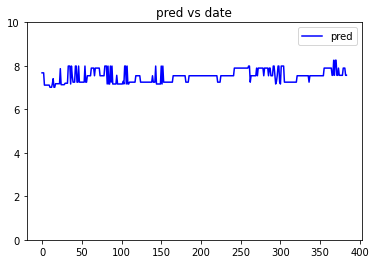

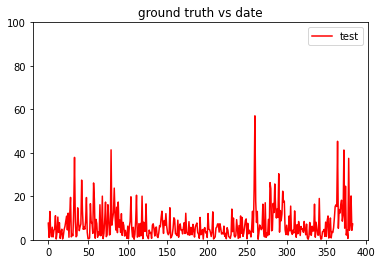

In [44]:
plt.plot(range(len(y_pred.tolist())), y_pred.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date")
plt.ylim([0,10])
plt.figure()
plt.plot(range(len(y_pred.tolist())), y_test.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date")
plt.ylim([0, 100])

In [45]:
y_pred_risk = y_pred

### draw graph

In [46]:
x_train_benefit, y_train_benefit, x_test_benefit, y_test_benefit, x_valid_benefit, y_valid_benefit = benefit_datasets
x_train_risk, y_train_risk, x_test_risk, y_test_risk, x_valid_risk, y_valid_risk = risk_datasets

(-100.0, 100.0)

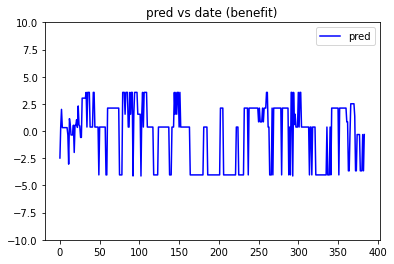

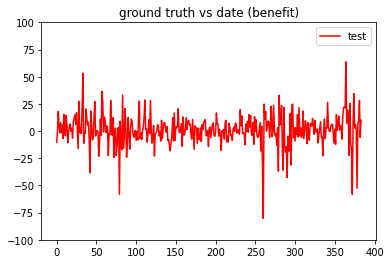

In [47]:
plt.plot(range(len(y_pred_benefit.tolist())), y_pred_benefit.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (benefit)")
plt.ylim([-10, 10])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (benefit)")
plt.ylim([-100, 100])

(-100.0, 100.0)

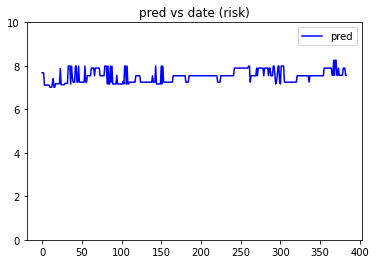

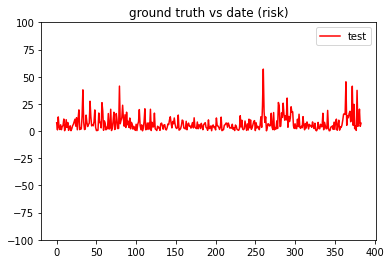

In [48]:
plt.plot(range(len(y_pred_risk.tolist())), y_pred_risk.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (risk)")
plt.ylim([0, 10])
plt.figure()
plt.plot(range(len(y_pred_risk.tolist())), y_test_risk.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (risk)")
plt.ylim([-100, 100])

(-2.0, 2.0)

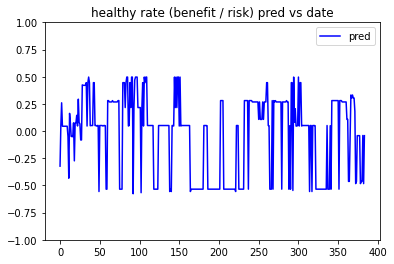

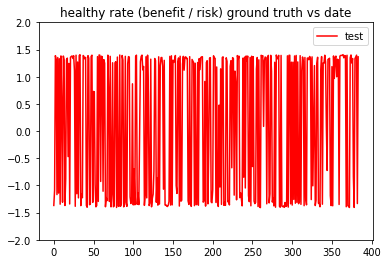

In [49]:
# the larger the health, the better the stock is
plt.plot(range(len(y_pred_benefit.tolist())), y_pred_benefit / y_pred_risk.tolist(), 'b', label='pred')
plt.legend()
plt.title("healthy rate (benefit / risk) pred vs date")
plt.ylim([-1, 1])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target.div(y_test_risk.target), 'r', label='test')
plt.legend()
plt.title("healthy rate (benefit / risk) ground truth vs date")
plt.ylim([-2, 2])

### Inspect data

In [50]:
x_train_benefit, y_train_benefit, x_test_benefit, y_test_benefit, x_valid_benefit, y_valid_benefit = benefit_datasets
x_train_risk, y_train_risk, x_test_risk, y_test_risk, x_valid_risk, y_valid_risk = risk_datasets

In [51]:
benefit_dist = {}
for i in range(-19, 21):
    benefit_dist[((i - 1) * 5, i * 5)] = 0

In [52]:
risk_dist = {}
for i in range(1, 21):
    risk_dist[((i - 1) * 5, i * 5)] = 0

In [53]:
for i in range(y_train_benefit.target.size):
    num = y_train_benefit.target[i]
    num = int(num)
    benefit_dist[(num // 5 * 5, (num // 5 + 1) * 5)] += 1
print(benefit_dist)

{(-100, -95): 1, (-95, -90): 1, (-90, -85): 3, (-85, -80): 0, (-80, -75): 1, (-75, -70): 3, (-70, -65): 3, (-65, -60): 3, (-60, -55): 2, (-55, -50): 11, (-50, -45): 9, (-45, -40): 8, (-40, -35): 12, (-35, -30): 13, (-30, -25): 30, (-25, -20): 41, (-20, -15): 60, (-15, -10): 123, (-10, -5): 206, (-5, 0): 420, (0, 5): 605, (5, 10): 240, (10, 15): 158, (15, 20): 95, (20, 25): 58, (25, 30): 39, (30, 35): 18, (35, 40): 9, (40, 45): 5, (45, 50): 6, (50, 55): 1, (55, 60): 3, (60, 65): 0, (65, 70): 0, (70, 75): 1, (75, 80): 0, (80, 85): 1, (85, 90): 0, (90, 95): 0, (95, 100): 1}


In [54]:
for i in range(y_train_risk.target.size):
    num = y_train_risk.target[i]
    num = int(num)
    risk_dist[(num // 5 * 5, (num // 5 + 1) * 5)] += 1
print(risk_dist)

{(0, 5): 1166, (5, 10): 517, (10, 15): 233, (15, 20): 129, (20, 25): 59, (25, 30): 28, (30, 35): 21, (35, 40): 14, (40, 45): 7, (45, 50): 4, (50, 55): 4, (55, 60): 2, (60, 65): 3, (65, 70): 2, (70, 75): 1, (75, 80): 0, (80, 85): 0, (85, 90): 0, (90, 95): 0, (95, 100): 0}


Text(0.5, 1.0, 'risk data distribution')

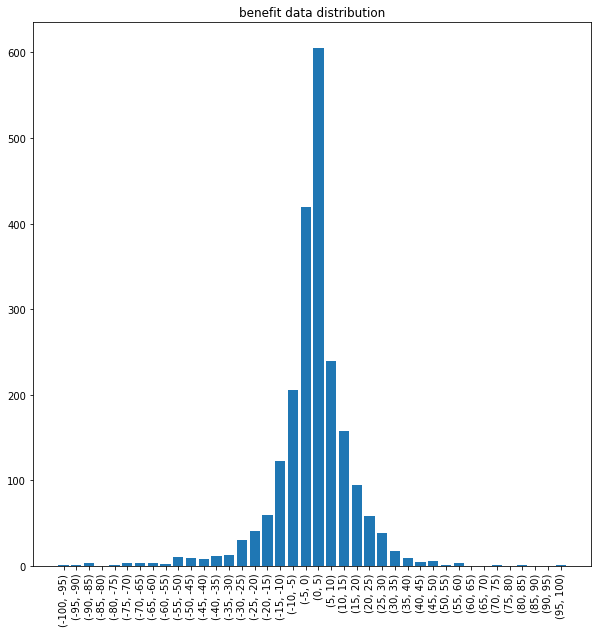

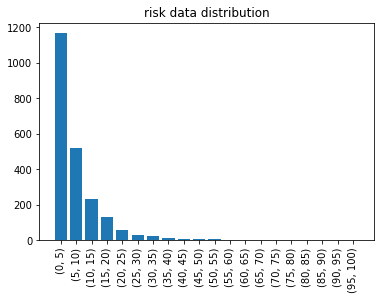

In [55]:
plt.figure(figsize=(10, 10))
plt.bar(list(map(str, benefit_dist.keys())), benefit_dist.values())
plt.xticks(rotation = 90)
plt.title("benefit data distribution")
plt.figure()
plt.bar(list(map(str, risk_dist.keys())), risk_dist.values())
plt.xticks(rotation = 90)
plt.title("risk data distribution")

### Train LSTM

In [56]:
class SequenceDataset(Dataset):
    def __init__(self, dataframe, target, features):
        self.features = features
        self.target = target
        self.y = torch.tensor(dataframe[target].values).float()
        self.X = torch.tensor(dataframe[features].values).float()

    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, i):
        return self.X[i].expand(1, -1), self.y[i]

In [57]:
class ShallowRegressionLSTM(nn.Module):
    def __init__(self, num_sensors, hidden_units):
        super().__init__()
        self.num_sensors = num_sensors  # this is the number of features
        self.hidden_units = hidden_units
        self.num_layers = 2

        self.lstm = nn.LSTM(
            input_size=num_sensors,
            hidden_size=hidden_units,
            batch_first=True,
            num_layers=self.num_layers
        )

        self.linear = nn.Linear(in_features=self.hidden_units, out_features=1)

    def forward(self, x):
        batch_size = x.shape[0]
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_units).requires_grad_()

        _, (hn, _) = self.lstm(x, (h0, c0))
        out = self.linear(hn[0]).flatten()  # First dim of Hn is num_layers, which is set to 1 above.

        return out

In [58]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()

    for X, y in data_loader:
        print(X, y)
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")

def test_model(data_loader, model, loss_function):

    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()
            print(y, output)

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")

def predict(data_loader, model):

    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)

    return output

### Benefit LSTM

In [59]:
provider_uri = "./dataset/dataset_benefit2_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

[22440:MainThread](2022-06-29 19:48:13,306) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[22440:MainThread](2022-06-29 19:48:13,312) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[22440:MainThread](2022-06-29 19:48:13,314) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_benefit2_bin')}
[22440:MainThread](2022-06-29 19:48:13,434) INFO - qlib.timer - [log.py:113] - Time cost: 0.009s | Loading data Done
[22440:MainThread](2022-06-29 19:48:13,436) INFO - qlib.timer - [log.py:113] - Time cost: 0.001s | Fillna Done
[22440:MainThread](2022-06-29 19:48:13,437) INFO - qlib.timer - [log.py:113] - Time cost: 0.002s | fit & process data Done
[22440:MainThread](2022-06-29 19:48:13,438) INFO - qlib.timer - [log.py:113] - Time cost: 0.012s | Init data Done


In [60]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

risk_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [61]:
benefit_train_dataset = SequenceDataset(ds.prepare('train'), 'target', ['open', 'close', 'high', 'low'])
benefit_train_loader = DataLoader(benefit_train_dataset, batch_size=1, shuffle=True)

benefit_test_dataset = SequenceDataset(ds.prepare('test'), 'target', ['open', 'close', 'high', 'low'])
benefit_test_loader = DataLoader(benefit_test_dataset, batch_size=1, shuffle=True)

benefit_valid_dataset = SequenceDataset(ds.prepare('valid'), 'target', ['open', 'close', 'high', 'low'])
benefit_valid_loader = DataLoader(benefit_valid_dataset, batch_size=1, shuffle=True)

In [62]:
learning_rate = 1e-3
num_hidden_units = 10

model = ShallowRegressionLSTM(num_sensors=4, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [63]:
print("Untrained test\n--------")
test_model(benefit_valid_loader, model, loss_function)
print()

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(benefit_train_loader, model, loss_function, optimizer=optimizer)
    test_model(benefit_valid_loader, model, loss_function)
    print()

Untrained test
--------
tensor([-2.8032]) tensor([0.1686])
tensor([-10.8034]) tensor([0.1654])
tensor([-9.0380]) tensor([0.1628])
tensor([-7.4406]) tensor([0.1686])
tensor([1.9460]) tensor([0.1682])
tensor([1.6866]) tensor([0.1663])
tensor([21.8179]) tensor([0.1698])
tensor([3.8920]) tensor([0.1604])
tensor([2.5107]) tensor([0.1717])
tensor([5.2707]) tensor([0.1696])
tensor([3.0729]) tensor([0.1700])
tensor([-0.5164]) tensor([0.1665])
tensor([10.4167]) tensor([0.1699])
tensor([1.3482]) tensor([0.1613])
tensor([-19.4421]) tensor([0.1602])
tensor([1.7222]) tensor([0.1674])
tensor([1.2363]) tensor([0.1644])
tensor([-3.3222]) tensor([0.1706])
tensor([11.6276]) tensor([0.1693])
tensor([-5.4208]) tensor([0.1622])
tensor([-18.7883]) tensor([0.1589])
tensor([4.0649]) tensor([0.1671])
tensor([5.0366]) tensor([0.1722])
tensor([22.2453]) tensor([0.1612])
tensor([-11.5207]) tensor([0.1704])
tensor([-7.2625]) tensor([0.1669])
tensor([4.8866]) tensor([0.1663])
tensor([9.4094]) tensor([0.1676])
tenso

In [64]:
y_pred_benefit = predict(benefit_test_loader, model)

In [65]:
print(y_pred_benefit)

tensor([-1.8610, -2.1227, -2.2055, -2.2041, -2.1653, -2.1418, -1.9887, -2.0181,
        -2.3733, -2.1202, -2.4735, -2.1459, -2.1908, -2.1576, -2.3008, -1.7374,
        -2.1202, -2.0216, -2.1707, -1.9482, -2.0207, -1.8025, -2.0321, -2.0280,
        -1.9204, -1.9174, -1.4456, -1.9534, -2.0519, -2.0622, -1.9669, -1.9689,
        -1.9005, -2.5039, -2.7282, -2.1472, -2.0305, -2.4422, -1.7997, -2.8205,
        -2.0158, -2.3159, -1.9727, -2.0321, -2.0556, -2.1455, -2.0174, -1.6917,
        -2.0931, -2.0150, -2.0077, -1.7560, -2.0113, -2.1825, -2.1164, -2.0820,
        -2.1199, -2.1557, -2.1431, -2.1208, -1.8231, -2.0681, -2.0463, -2.2851,
        -2.0575, -1.9815, -2.0356, -1.4445, -2.1103, -2.0282, -1.9032, -1.9140,
        -2.0309, -2.0634, -2.0451, -1.9733, -2.0191, -2.1264, -1.9873, -1.7809,
        -1.8968, -1.9361, -1.8666, -2.0630, -2.0555, -2.1990, -1.9220, -1.9140,
        -2.0440, -2.1853, -2.1535, -2.1988, -1.4848, -1.9553, -1.9360, -1.9334,
        -1.8940, -2.0661, -2.2984, -1.97

### Risk LSTM

In [66]:
provider_uri = "./dataset/dataset_risk2_bin/"  # target_dir
qlib.init(provider_uri=provider_uri, region=REG_CN)
fields = ['$open', '$close', '$high', '$low', '$volumn', '$factor', '$adjclose', '$change', '$money', '$target']
qdl = QlibDataLoader(config=[fields, ['open', 'close', 'high', 'low', 'volumn', 'factor', 'adjclose', 'change', 'money', 'target']])
qdl.load(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01')
dh = DataHandlerLP(instruments=['sh000300'], start_time='2008-01-01', end_time='2020-08-01',
             infer_processors=[Fillna()],
             data_loader=qdl)
ds = DatasetH(dh, segments={"train": ("2008-01-01", "2016-12-31"), "valid": ("2017-01-01", "2018-12-31"), "test": ("2019-01-01", "2020-08-01")})

[22440:MainThread](2022-06-29 19:50:14,804) INFO - qlib.Initialization - [config.py:402] - default_conf: client.
[22440:MainThread](2022-06-29 19:50:14,807) INFO - qlib.Initialization - [__init__.py:74] - qlib successfully initialized based on client settings.
[22440:MainThread](2022-06-29 19:50:14,809) INFO - qlib.Initialization - [__init__.py:76] - data_path={'__DEFAULT_FREQ': WindowsPath('C:/Users/v-junmzhang/qlib/examples/dataset/dataset_risk2_bin')}
[22440:MainThread](2022-06-29 19:50:14,933) INFO - qlib.timer - [log.py:113] - Time cost: 0.008s | Loading data Done
[22440:MainThread](2022-06-29 19:50:14,934) INFO - qlib.timer - [log.py:113] - Time cost: 0.000s | Fillna Done
[22440:MainThread](2022-06-29 19:50:14,935) INFO - qlib.timer - [log.py:113] - Time cost: 0.001s | fit & process data Done
[22440:MainThread](2022-06-29 19:50:14,937) INFO - qlib.timer - [log.py:113] - Time cost: 0.013s | Init data Done


In [67]:
x_train, y_train = ds.prepare('train')[['open', 'close', 'high', 'low']], ds.prepare('train')[['target']]
x_test, y_test = ds.prepare('test')[['open', 'close', 'high', 'low']], ds.prepare('test')[['target']]
x_valid, y_valid = ds.prepare('valid')[['open', 'close', 'high', 'low']], ds.prepare('valid')[['target']]

risk_datasets = [x_train, y_train, x_test, y_test, x_valid, y_valid]

In [68]:
risk_train_dataset = SequenceDataset(ds.prepare('train'), 'target', ['open', 'close', 'high', 'low'])
risk_train_loader = DataLoader(risk_train_dataset, batch_size=1, shuffle=True)

risk_test_dataset = SequenceDataset(ds.prepare('test'), 'target', ['open', 'close', 'high', 'low'])
risk_test_loader = DataLoader(risk_test_dataset, batch_size=1, shuffle=True)

risk_valid_dataset = SequenceDataset(ds.prepare('valid'), 'target', ['open', 'close', 'high', 'low'])
risk_valid_loader = DataLoader(risk_valid_dataset, batch_size=1, shuffle=True)

In [69]:
learning_rate = 1e-2
num_hidden_units = 10

model = ShallowRegressionLSTM(num_sensors=4, hidden_units=num_hidden_units)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [70]:
print("Untrained test\n--------")
test_model(risk_valid_loader, model, loss_function)
print()

for ix_epoch in range(20):
    print(f"Epoch {ix_epoch}\n---------")
    train_model(risk_train_loader, model, loss_function, optimizer=optimizer)
    test_model(risk_valid_loader, model, loss_function)
    print()

Untrained test
--------
tensor([8.4396]) tensor([-0.2714])
tensor([3.9770]) tensor([-0.2710])
tensor([14.1290]) tensor([-0.2696])
tensor([4.5561]) tensor([-0.2716])
tensor([2.5308]) tensor([-0.2667])
tensor([1.3490]) tensor([-0.2643])
tensor([0.4910]) tensor([-0.2703])
tensor([3.4715]) tensor([-0.2717])
tensor([1.7699]) tensor([-0.2703])
tensor([2.9139]) tensor([-0.2705])
tensor([4.0831]) tensor([-0.2677])
tensor([0.3184]) tensor([-0.2708])
tensor([0.5449]) tensor([-0.2713])
tensor([17.6526]) tensor([-0.2659])
tensor([0.5738]) tensor([-0.2713])
tensor([2.3833]) tensor([-0.2675])
tensor([6.7272]) tensor([-0.2713])
tensor([6.9358]) tensor([-0.2664])
tensor([8.6968]) tensor([-0.2702])
tensor([5.1263]) tensor([-0.2683])
tensor([4.5651]) tensor([-0.2718])
tensor([3.8367]) tensor([-0.2704])
tensor([0.9011]) tensor([-0.2688])
tensor([24.0489]) tensor([-0.2697])
tensor([7.8190]) tensor([-0.2665])
tensor([0.3417]) tensor([-0.2709])
tensor([6.9592]) tensor([-0.2657])
tensor([2.7988]) tensor([-0.

In [71]:
y_pred_risk = predict(risk_test_loader, model)
print(y_pred_risk)

tensor([13.7325, 17.3941, 12.8361,  8.0365, 13.2393, 13.4829, 13.0728, 12.0969,
        12.2253, 13.1633, 14.3464, 14.0024, 12.1206, 15.1561, 13.1370, 12.7763,
        12.9307, 13.5844, 12.6750, 12.5936, 15.2270, 12.5037, 12.4216, 13.8860,
        11.3856, 14.9069, 14.6073, 14.9529, 12.7643, 10.9507, 13.9237, 12.5136,
        10.8300, 12.1698, 13.2039, 11.0710, 12.7334, 12.0216, 13.6958, 11.2190,
        10.6303, 13.2734, 15.2671, 16.1652, 12.8947, 15.0135, 12.1885, 15.0360,
        13.2303,  7.3938, 14.6606, 11.2736, 11.1400, 12.5783, 12.9246, 12.4054,
        14.0856, 15.5271, 15.0620, 12.8265, 12.8840, 13.8383,  8.2445, 14.8106,
        12.9322, 17.4838, 12.9473,  6.3963, 15.1223, 14.3535,  6.5530, 13.4914,
        17.7358, 14.2893, 13.7851, 11.1683, 14.7266, 13.8901,  7.4227, 14.0721,
        12.9864, 12.7428, 12.6177, 11.7202, 14.7253, 13.9007, 14.1831,  7.3712,
        17.4433,  9.4558, 14.9192, 14.3305, 12.8115, 11.6631,  7.5844,  6.9133,
        12.5505, 12.7032, 11.5516, 12.87

### Draw graph

In [72]:
x_train_benefit, y_train_benefit, x_test_benefit, y_test_benefit, x_valid_benefit, y_valid_benefit = benefit_datasets
x_train_risk, y_train_risk, x_test_risk, y_test_risk, x_valid_risk, y_valid_risk = risk_datasets

(-100.0, 100.0)

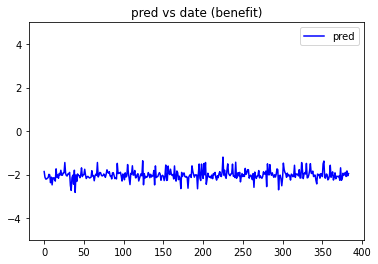

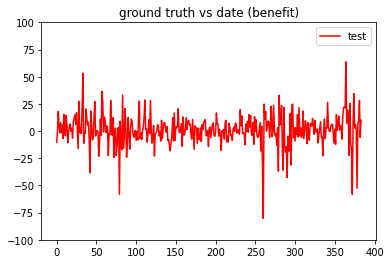

In [76]:
plt.plot(range(len(y_pred_benefit.tolist())), y_pred_benefit.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (benefit)")
plt.ylim([-5, 5])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (benefit)")
plt.ylim([-100, 100])

(0.0, 100.0)

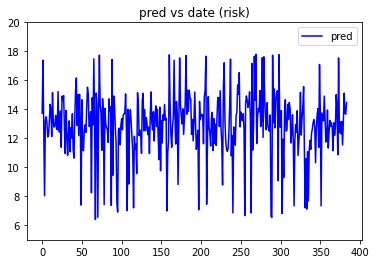

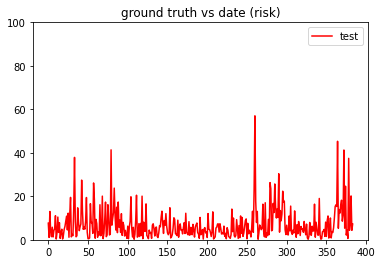

In [74]:
plt.plot(range(len(y_pred_risk.tolist())), y_pred_risk.tolist(), 'b', label='pred')
plt.legend()
plt.title("pred vs date (risk)")
plt.ylim([5, 20])
plt.figure()
plt.plot(range(len(y_pred_risk.tolist())), y_test_risk.target, 'r', label='test')
plt.legend()
plt.title("ground truth vs date (risk)")
plt.ylim([0, 100])

(-2.0, 2.0)

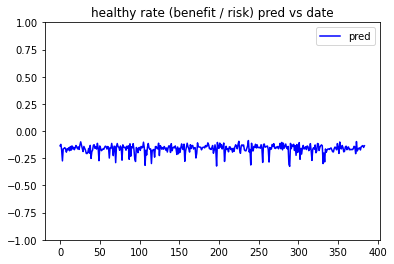

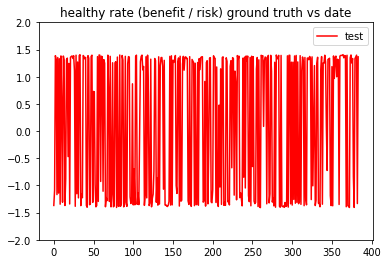

In [75]:
# the larger the health, the better the stock is
plt.plot(range(len(y_pred_benefit.tolist())), (y_pred_benefit / y_pred_risk).tolist(), 'b', label='pred')
plt.legend()
plt.title("healthy rate (benefit / risk) pred vs date")
plt.ylim([-1, 1])
plt.figure()
plt.plot(range(len(y_pred_benefit.tolist())), y_test_benefit.target.div(y_test_risk.target), 'r', label='test')
plt.legend()
plt.title("healthy rate (benefit / risk) ground truth vs date")
plt.ylim([-2, 2])